## Assignment 1 
##### Kazantza Katerina (p3351801)

#### Question 1)
#### a) Gauss Elimination with Complete Pivoting

In [1]:
import scipy
import numpy as np
import scipy.linalg 
from numpy import linalg as npla
import time
from numpy.random import seed
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def completePivotingGE(A,verbose):
    A=A.astype(float)
    if verbose:print(A)
    (n,n) = A.shape
    p=np.arange(0,n)
    q=np.arange(0,n)
    if verbose:print('p',p,'q',q)
    for k in range(0,n):
        maxc,rowindices = np.amax(np.absolute(A[k:n,k:n]), axis=0) ,np.argmax(np.absolute(A[k:n,k:n]),axis=0)
        if verbose:print('maxc',maxc,'rowindices',rowindices)
        maxm = np.max(maxc)
        if verbose:print('maxm',maxm)
        # get [1] value for column index
        colindexformax = np.where(np.absolute(A[k:n,k:n]) == maxm)[1]
        if verbose:print('np.where(A[k:n,k:n] == maxm),',colindexformax,'colindexformax[0]: ',colindexformax[0])
        colindex = np.asscalar(colindexformax[0])
        if verbose:print('maxm',maxm,'colindex',colindex)
        row = rowindices[colindex]+k
        col = colindex+k
        if verbose:print('row',row,'col',col)
        A[[k, row],:] = A[[row, k],:]
        if verbose:print('swap rows:','[',k,',',row,']')
        if verbose:print(A)
        A[:,[k, col]] = A[:,[col, k]]
        if verbose:print('swap columns:','[',k,',',col,']')
        if verbose:print(A)
        p[[k, row]] = p[[row, k]]
        q[[k, col]] = q[[col, k]]
        if verbose:print('p',p,'q',q)
        if A[k,k] == 0:
            break
        A[k+1:n,k] = A[k+1:n,k]/A[k,k]
        A[k+1:n,k+1:n] = A[k+1:n,k+1:n] - np.tensordot(A[k+1:n,k], A[k,k+1:n],axes = 0)
        if verbose:print('A',A)
        if verbose:print('-----------------------------------------------------------------')
    L = np.tril(A,-1) + np.eye(n)
    U = np.triu(A)
    P = np.eye(n)
    P = P[p,:]
    Q = np.eye(n)
    Q = Q[:,q]
    return L, U, P, Q

**[L,U,P,Q] = completePivotingGE(A,verbose)** returns unit lower triangular matrix L, upper
<br> triangular matrix U,  permutation matrix P and permutation matrix Q so that PAQ = LU.

In [3]:
# cross check
A =  np.array([[ 0.05056171,0.49995133,-0.99590893,0.69359851],[-0.41830152,-1.58457724,-0.64770677,0.59857517],[0.33225003,-1.14747663,0.61866969,-0.08798693],[ 0.4250724,0.33225315,-1.15681626,0.35099715]])
Lcomp,Ucomp,Pcomp,Qcomp = completePivotingGE(A,False)
print('PAQ = LU:',np.allclose(Pcomp@A@Qcomp, Lcomp@Ucomp))

PAQ = LU: True


#### b) Gauss Elimination with Partial Pivoting

In [4]:
def partialPivotingGE(A,verbose):
    A=A.astype(float)
    if verbose:print(A)
    (n,n) = A.shape
    p=np.arange(0,n)
    for k in range(0,n):
        maxval,row = np.max(np.absolute(A[k:n,k]), axis=0),np.argmax(np.absolute(A[k:n,k]),axis=0)
        if verbose:print('maxval',maxval,'row',row)
        col = k
        row = row + k
        if verbose:print('row',row,'col',col)
        A[[k, row],:] = A[[row, k],:]
        if verbose:print('swap rows:','[',k,',',row,']')
        if verbose:print(A)
        # swap current row k with max value row
        p[[k, row]] = p[[row, k]]
        if verbose:print('p',p)
        if A[k,k] == 0:
            break
        A[k+1:n,k] = A[k+1:n,k]/A[k,k]
        A[k+1:n,k+1:n] = A[k+1:n,k+1:n] - np.tensordot(A[k+1:n,k], A[k,k+1:n],axes = 0)
        if verbose:print('after substraction A=\n',A)
        if verbose:print('-----------------------------------------------------------------')
    L = np.tril(A,-1) + np.eye(n)
    U = np.triu(A)
    P = np.eye(n)
    P = P[p,:]    
    return L, U, P

**[L,U,P] = partialPivotingGE(A,verbose)** returns unit lower triangular matrix L, upper
<br> triangular matrix U and permutation matrix P so that PA = LU.

In [5]:
# cross check
A =  np.array([[ 0.05056171,0.49995133,-0.99590893,0.69359851],[-0.41830152,-1.58457724,-0.64770677,0.59857517],[0.33225003,-1.14747663,0.61866969,-0.08798693],[ 0.4250724,0.33225315,-1.15681626,0.35099715]])
Lpart, Upart, Ppart = partialPivotingGE(A,False)

print('PA = LU:',np.allclose(Ppart@A, Lpart@Upart))

PA = LU: True


#### Question 2)

* We will solve a random linear system by applying LU decomposition with Gauss Elimination Complete/Partial Pivoting for **n=64, 128, 256, 512, 1024, 2048.** Then we will compare the error residual for complete vs partial pivoting and CPU timing each method consumes for execution.

In [6]:
def getLinearSystemForN(n):
    seed(4)
    A = np.random.randn(n,n)
    x = np.random.randn(n,1)
    print('matrix A for n:',n)
    print(A)
    print('solution vector x for n:',n)
    print(x)
    b = np.dot(A,x)
    return A,x,b

Having estimated the LU decomposition with complete pivoting we have to solve the linear system **P.T U Q.T x = b**.
<br> We will break the system into three equations: **L z = P b**, **U y = z** and **y = Q.T x**.

In [7]:
def completePivotingRandomn(A,b,verbose):
    print('LU decomposition with Gauss Elimination Complete Pivoting')
    Lcomp,Ucomp,Pcomp,Qcomp = completePivotingGE(A,verbose)
    z=scipy.linalg.solve(Lcomp,Pcomp@b)
    y=scipy.linalg.solve(Ucomp,z)
    x=scipy.linalg.solve(Qcomp.T,y)
    print("Solutions:\n",x)
    return x

Having estimated the LU decomposition with Partial Pivoting **P A = L U**, it is equivalent to **A = P.T L U.** Then the original system is: **P.T L U x = b**
<br> We will break the system into two equations: **L y = P b** and **y = U x**.

In [8]:
def partialPivotingRandomn(A,b,verbose):
    print('LU decomposition with Gauss Elimination Partial Pivoting')
    Lpart, Upart, Ppart = partialPivotingGE(A,verbose)
    y=scipy.linalg.solve(Lpart,Ppart@b)
    x=scipy.linalg.solve(Upart,y)
    print("Solutions:\n",x)
    return x

In [46]:
n = [64, 128, 256, 512, 1024, 2048]
errorsPP=[]
errorsCP=[]
condnumbers=[]

To check how good the computations are, we are going to check $\hat{x} := A^{-1}b$ and to compare it with actual **x.**
<br> The difference $r = \hat{x}−x$ is called the residual and we will compare it for the two factorization methods. 

We are going to use for the estimation of the error and the condition number the **infinite norm.**

In [47]:
def runAndDisplayResults(A,x,b,verbosePP,verboseCP):
    mcond = npla.cond(A, np.inf)
    condnumbers.append(mcond)
    print('Matrix: ',n,'x',n,'condition number:',mcond)

    start = time.time()
    x_estimate = partialPivotingRandomn(A,b,verbosePP)
    end = time.time()
    print('CPU time PP: ',end - start)
    error = npla.norm(x_estimate-x, np.inf)
    errorsPP.append(error)
    # Time in seconds
    print('error PP: ',error)

    start = time.time()
    x_estimate = completePivotingRandomn(A,b,verboseCP)
    end = time.time()
    # Time in seconds
    print('CPU time CP: ',end - start)

    error = npla.norm(x_estimate-x, np.inf)
    errorsCP.append(error)
    print('error CP: ',error)
    print('---------------------------------------------------------')

In [38]:
verbosePP,verboseCP=False,False

In [48]:
    n = 64
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 64
[[ 0.05056171  0.49995133 -0.99590893 ...  0.3523434   0.067471
  -0.7322647 ]
 [ 0.29714121 -0.9617768   1.27181862 ...  0.51655963  0.67380149
   1.02645497]
 [-0.68114843 -1.96601472  1.04090637 ... -1.97175308 -0.92708219
   0.34374145]
 ...
 [ 0.367727   -0.32034449 -1.75607263 ... -0.27950187 -0.86224063
  -1.27712852]
 [-1.26464051  0.36997555 -0.67398211 ...  1.54574563  0.27112793
   1.38286855]
 [-0.56783291  2.01625366 -0.60787455 ... -1.63875863  0.86140911
  -1.21189758]]
solution vector x for n: 64
[[ 0.69834862]
 [-0.03288943]
 [ 0.37951421]
 [-0.80497322]
 [ 1.10851421]
 [-0.40155605]
 [ 0.02746032]
 [-0.07929173]
 [-0.57977827]
 [ 0.03573742]
 [-0.60520969]
 [ 0.65338477]
 [-0.82689175]
 [-0.05076208]
 [-0.21804545]
 [ 0.47545254]
 [-0.02713303]
 [ 0.17975221]
 [-0.49170994]
 [-1.07218889]
 [-0.42396604]
 [ 0.79995441]
 [ 0.20988126]
 [-0.5719529 ]
 [-0.14629356]
 [-1.54493454]
 [ 0.09209576]
 [ 0.17937177]
 [-0.44295485]
 [ 0.49217951]
 [-1.54305065

In [49]:
n = 128
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 128
[[ 0.05056171  0.49995133 -0.99590893 ...  0.51655963  0.67380149
   1.02645497]
 [-0.68114843 -1.96601472  1.04090637 ... -0.42976675 -1.22719015
   0.77399926]
 [-0.75187076 -0.11374508  0.7130868  ...  0.64541573 -0.11350211
  -2.07141668]
 ...
 [ 0.96503614  0.04741033 -0.08297412 ... -1.44310058 -0.38718819
  -0.91891134]
 [ 0.03725246  0.79302259  2.53892772 ... -0.23128264 -0.80452312
   0.18620104]
 [-0.44498235  0.67284416  0.13918271 ... -0.13094001 -1.06544595
   0.37164037]]
solution vector x for n: 128
[[ 1.70766586]
 [ 0.41363416]
 [ 1.45738636]
 [-1.28633022]
 [ 0.49759865]
 [-0.82116052]
 [-0.03361031]
 [ 1.71940872]
 [ 0.08543582]
 [-0.6757606 ]
 [ 0.83650962]
 [-0.24232479]
 [-1.45206346]
 [-1.53256008]
 [ 0.26452933]
 [-0.24008753]
 [ 1.78333996]
 [ 0.11124812]
 [-0.4416417 ]
 [-1.09754098]
 [ 1.06358941]
 [-2.52832546]
 [-0.81900164]
 [-1.56867605]
 [-0.24777925]
 [ 1.24687076]
 [ 1.79366648]
 [-0.29077914]
 [ 0.57647749]
 [-0.58134034]
 [ 0.9307

In [50]:
n = 256
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 256
[[ 0.05056171  0.49995133 -0.99590893 ... -0.42976675 -1.22719015
   0.77399926]
 [-0.75187076 -0.11374508  0.7130868  ...  0.14593007  0.03424651
   1.99565981]
 [-0.06712705  1.12097388 -0.39180021 ... -0.555885   -1.60167756
   1.14373446]
 ...
 [-0.49313863 -1.01168966 -0.04909124 ...  0.61635885  0.1890873
   1.01963375]
 [-1.80369017  0.45833357 -0.73164468 ...  1.58072073  0.85198322
   0.85772026]
 [ 0.14237189 -0.06370854 -0.45341981 ...  0.66296277 -1.15178951
  -0.10938702]]
solution vector x for n: 256
[[-3.60036635e-01]
 [ 1.25447390e+00]
 [-5.93814993e-01]
 [-2.05820521e-01]
 [ 1.31337022e+00]
 [ 1.47129227e+00]
 [-2.48699996e+00]
 [-1.77876600e+00]
 [-8.43376229e-01]
 [-7.87352277e-01]
 [-1.80977943e+00]
 [ 1.73291156e+00]
 [-8.99882457e-01]
 [ 1.00969930e+00]
 [ 5.18536676e-01]
 [ 8.36260513e-01]
 [-8.63224834e-02]
 [ 1.87760814e+00]
 [-1.34599379e-01]
 [-5.05876994e-01]
 [ 3.29820794e-01]
 [-1.65741741e-03]
 [ 9.85809290e-02]
 [ 1.34965247e-01]
 [ 9

Solutions:
 [[-3.60036635e-01]
 [ 1.25447390e+00]
 [-5.93814993e-01]
 [-2.05820521e-01]
 [ 1.31337022e+00]
 [ 1.47129227e+00]
 [-2.48699996e+00]
 [-1.77876600e+00]
 [-8.43376229e-01]
 [-7.87352277e-01]
 [-1.80977943e+00]
 [ 1.73291156e+00]
 [-8.99882457e-01]
 [ 1.00969930e+00]
 [ 5.18536676e-01]
 [ 8.36260513e-01]
 [-8.63224834e-02]
 [ 1.87760814e+00]
 [-1.34599379e-01]
 [-5.05876994e-01]
 [ 3.29820794e-01]
 [-1.65741741e-03]
 [ 9.85809290e-02]
 [ 1.34965247e-01]
 [ 9.68144130e-01]
 [ 7.17781517e-01]
 [-2.58977846e-01]
 [ 1.32461620e+00]
 [-1.48919591e+00]
 [ 1.74171143e+00]
 [-1.79770486e-01]
 [ 7.30687635e-01]
 [-8.16656404e-01]
 [ 1.35820522e+00]
 [ 1.20857872e+00]
 [ 7.30169372e-01]
 [ 9.59268025e-01]
 [-1.02858259e+00]
 [ 8.04871254e-02]
 [ 9.43718349e-01]
 [ 5.45741009e-01]
 [-1.25849168e+00]
 [ 1.23243536e+00]
 [-8.28951641e-01]
 [ 1.44504158e+00]
 [ 6.58181453e-01]
 [ 7.40999579e-01]
 [ 1.82696693e-02]
 [-2.47839027e-01]
 [ 3.35021557e-01]
 [ 3.91703091e-01]
 [-1.15229478e+00]


In [51]:
n = 512
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 512
[[ 0.05056171  0.49995133 -0.99590893 ...  0.14593007  0.03424651
   1.99565981]
 [-0.06712705  1.12097388 -0.39180021 ... -0.98256726 -0.78958707
  -2.1679968 ]
 [ 0.07351754  2.19522353  1.78769273 ... -0.33004162 -0.48753191
  -1.25062792]
 ...
 [ 0.45239186  0.04712583 -1.23752039 ...  0.29473296  0.94979254
   0.01771761]
 [ 0.17265275  0.42605504  1.5148798  ...  1.17456206 -0.20561148
   0.78836899]
 [-0.60721858  0.49668808 -0.40288219 ... -1.07231559 -0.67281388
  -1.11057421]]
solution vector x for n: 512
[[ 0.16667885]
 [ 2.27993281]
 [-0.65439507]
 [ 0.68282646]
 [-0.46726043]
 [ 0.06225689]
 [-0.19047839]
 [ 0.95870169]
 [-0.4084825 ]
 [-0.96853721]
 [ 0.49754332]
 [ 0.9849579 ]
 [ 0.58142988]
 [ 0.11780057]
 [ 0.67093643]
 [-1.83441729]
 [-0.75542784]
 [ 0.02084429]
 [-0.06017766]
 [ 0.57255288]
 [-0.70331583]
 [ 0.42087317]
 [-1.39528329]
 [-0.22080227]
 [-1.33242804]
 [ 0.96681532]
 [-0.40902837]
 [-0.1566774 ]
 [ 0.65048733]
 [-1.10282528]
 [ 0.6653

Solutions:
 [[ 0.16667885]
 [ 2.27993281]
 [-0.65439507]
 [ 0.68282646]
 [-0.46726043]
 [ 0.06225689]
 [-0.19047839]
 [ 0.95870169]
 [-0.4084825 ]
 [-0.96853721]
 [ 0.49754332]
 [ 0.9849579 ]
 [ 0.58142988]
 [ 0.11780057]
 [ 0.67093643]
 [-1.83441729]
 [-0.75542784]
 [ 0.02084429]
 [-0.06017766]
 [ 0.57255288]
 [-0.70331583]
 [ 0.42087317]
 [-1.39528329]
 [-0.22080227]
 [-1.33242804]
 [ 0.96681532]
 [-0.40902837]
 [-0.1566774 ]
 [ 0.65048733]
 [-1.10282528]
 [ 0.66535531]
 [ 2.03956049]
 [-2.07283196]
 [-1.83317901]
 [-0.4462407 ]
 [ 0.56682401]
 [-0.36897943]
 [ 0.72521628]
 [-0.63217437]
 [ 1.87398104]
 [-0.40546744]
 [-0.39856734]
 [ 1.87383491]
 [ 0.56978246]
 [ 0.62410145]
 [ 0.30743013]
 [-0.39802244]
 [-1.5663395 ]
 [-0.32378448]
 [ 0.53771656]
 [-0.12059781]
 [ 0.21902123]
 [ 0.39303191]
 [-1.54714166]
 [-1.13172707]
 [-0.18093304]
 [-0.1999383 ]
 [-0.99289354]
 [-0.825325  ]
 [-1.43440614]
 [-0.20273296]
 [ 1.57597618]
 [-0.03426775]
 [-0.42353432]
 [-0.48829313]
 [-0.63046198

In [53]:
n = 1024
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 1024
[[ 0.05056171  0.49995133 -0.99590893 ... -0.98256726 -0.78958707
  -2.1679968 ]
 [ 0.07351754  2.19522353  1.78769273 ...  1.25263583 -0.20679488
   2.14888335]
 [ 0.26373261  0.01885877 -0.75896991 ... -0.1303388  -0.26742429
  -1.22226372]
 ...
 [ 0.52493422 -0.45877502  0.09347016 ...  0.51317429 -0.0523964
   1.01625543]
 [ 1.78863827 -1.30389395 -1.15779238 ...  0.2625558   0.42708983
  -0.85099429]
 [-0.76806231 -1.04327143  1.53159052 ...  2.01155427  1.30175947
   0.67430215]]
solution vector x for n: 1024
[[ 0.32560468]
 [ 0.95682323]
 [ 0.70486885]
 ...
 [-0.23027193]
 [-1.15499405]
 [ 0.05702714]]
Matrix:  1024 x 1024 condition number: 158447.48338174072
LU decomposition with Gauss Elimination Partial Pivoting
Solutions:
 [[ 0.32560468]
 [ 0.95682323]
 [ 0.70486885]
 ...
 [-0.23027193]
 [-1.15499405]
 [ 0.05702714]]
CPU time PP:  5.7996625900268555
error PP:  9.177103521551544e-13
LU decomposition with Gauss Elimination Complete Pivoting
Solutions:
 [[ 

In [54]:
n = 2048
A,x,b = getLinearSystemForN(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 2048
[[ 0.05056171  0.49995133 -0.99590893 ...  1.25263583 -0.20679488
   2.14888335]
 [ 0.26373261  0.01885877 -0.75896991 ... -1.63875863  0.86140911
  -1.21189758]
 [ 0.69834862 -0.03288943  0.37951421 ...  1.73316501  0.22018494
  -0.84014599]
 ...
 [ 0.62575363 -1.06928863 -0.81334672 ...  0.56406904  1.40687343
   2.33756597]
 [-0.53154193  0.50487601 -0.62422421 ... -0.51588697  1.53421473
  -0.5625584 ]
 [-0.48428727 -1.36186112  0.49177884 ... -0.95098529 -0.14682434
   0.16404892]]
solution vector x for n: 2048
[[ 1.13081224]
 [-0.91080736]
 [ 1.43107233]
 ...
 [ 1.10353642]
 [ 0.58327068]
 [-1.54079165]]
Matrix:  2048 x 2048 condition number: 474062.4180890948
LU decomposition with Gauss Elimination Partial Pivoting
Solutions:
 [[ 1.13081224]
 [-0.91080736]
 [ 1.43107233]
 ...
 [ 1.10353642]
 [ 0.58327068]
 [-1.54079165]]
CPU time PP:  49.76893973350525
error PP:  1.2533238336054353e-12
LU decomposition with Gauss Elimination Complete Pivoting
Solutions:
 [[ 

In [55]:
def multiplelineplot(df):
    plt.plot( 'Condition Number', 'Partial Pivoting', data=df, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
    plt.plot( 'Condition Number', 'Complete Pivoting', data=df, color='olive', linewidth=2)
    plt.legend()
    plt.xlabel('Condition Number')
    plt.ylabel('Error')
    plt.title('Errors vs Matrix Condition Number')

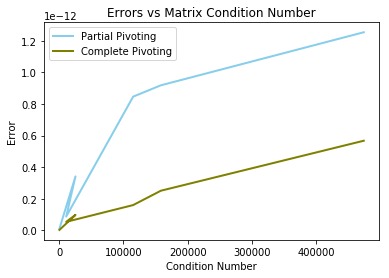

In [56]:
df=pd.DataFrame({'Partial Pivoting': errorsPP,'Complete Pivoting': errorsCP,'Condition Number': condnumbers})
multiplelineplot(df)


We can conclude from above solution of linear systems that when the n is increased so does the condition number of the matrix. The bigger the condition number is getting , more complex the system is becoming and as a sequence more time is needed to be solved.

Also, we can compare the execution time for each algorithm. We can see that the execution time for the partial pivoting when the n is small, is a bit faster than the complete pivoting. But as the n is increased, the execution time for each algorithm has a big difference with the complete pivoting performance to getting much worse.

To sum up, decomposition with complete pivoting is not recommended for big n, since the computations for the two permutation matrices for the rows and the columns make the algorithm inefficient.

#### Question 3)

In [60]:
def getLinearSystemForSpecialCase(n):
    A = np.ones((n,n),dtype=int)*(-1)
    A *= np.tri(*A.shape,-1,dtype=int)
    np.fill_diagonal(A, 1)
    last_col = np.ones(n, dtype=int)
    A[:,n-1]=last_col
    print('matrix A for n:',n)
    print(A)
    seed(4)
    x = np.random.randn(n,1)
    print('solution vector x for n:',n)
    print(x)
    b = np.dot(A,x)
    return A,x,b

In [61]:
verbosePP,verboseCP=False,False
n_array = [64, 128, 256, 512, 1024, 2048]
errorsPP=[]
errorsCP=[]
condnumbers=[]

In [62]:
n=64
A,x,b=getLinearSystemForSpecialCase(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

n=128
A,x,b=getLinearSystemForSpecialCase(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

n=256
A,x,b=getLinearSystemForSpecialCase(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

n=512
A,x,b=getLinearSystemForSpecialCase(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 64
[[ 1  0  0 ...  0  0  1]
 [-1  1  0 ...  0  0  1]
 [-1 -1  1 ...  0  0  1]
 ...
 [-1 -1 -1 ...  1  0  1]
 [-1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ... -1 -1  1]]
solution vector x for n: 64
[[ 0.05056171]
 [ 0.49995133]
 [-0.99590893]
 [ 0.69359851]
 [-0.41830152]
 [-1.58457724]
 [-0.64770677]
 [ 0.59857517]
 [ 0.33225003]
 [-1.14747663]
 [ 0.61866969]
 [-0.08798693]
 [ 0.4250724 ]
 [ 0.33225315]
 [-1.15681626]
 [ 0.35099715]
 [-0.60688728]
 [ 1.54697933]
 [ 0.72334161]
 [ 0.04613557]
 [-0.98299165]
 [ 0.05443274]
 [ 0.15989294]
 [-1.20894816]
 [ 2.22336022]
 [ 0.39429521]
 [ 1.69235772]
 [-1.11281215]
 [ 1.63574754]
 [-1.36096559]
 [-0.65122583]
 [ 0.54245131]
 [ 0.04800625]
 [-2.35807363]
 [-1.10558404]
 [ 0.83783635]
 [ 2.08787087]
 [ 0.91484096]
 [-0.27620335]
 [ 0.7965119 ]
 [-1.14379857]
 [ 0.50991978]
 [-1.3474603 ]
 [-0.0093601 ]
 [-0.13070464]
 [ 0.80208661]
 [-0.30296397]
 [ 1.20200259]
 [-0.19674528]
 [ 0.8365287 ]
 [ 0.78660228]
 [-1.84087587]
 [ 0.03754749]
 [

C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=1.69407e-21): result may not be accurate.
  after removing the cwd from sys.path.
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: LinAlgWarning: Ill-conditioned matrix (rcond=5.42101e-20): result may not be accurate.
  """
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=4.59177e-41): result may not be accurate.
  after removing the cwd from sys.path.
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: LinAlgWarning: Ill-conditioned matrix (rcond=2.93874e-39): result may not be accurate.
  """
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=6.74701e-80): result may not be accurate.
  after removing the cwd from sys.path.
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: LinAlgWarning: Ill-condit

Solutions:
 [[ 0.05056171]
 [ 0.49995133]
 [-0.99590893]
 [ 0.69359851]
 [-0.41830152]
 [-1.58457724]
 [-0.64770677]
 [ 0.59857517]
 [ 0.33225003]
 [-1.14747663]
 [ 0.61866969]
 [-0.08798693]
 [ 0.4250724 ]
 [ 0.33225315]
 [-1.15681626]
 [ 0.35099715]
 [-0.60688728]
 [ 1.54697933]
 [ 0.72334161]
 [ 0.04613557]
 [-0.98299165]
 [ 0.05443274]
 [ 0.15989294]
 [-1.20894816]
 [ 2.22336022]
 [ 0.39429522]
 [ 1.69235772]
 [-1.11281215]
 [ 1.63574755]
 [-1.36096555]
 [-0.65122581]
 [ 0.54245138]
 [ 0.04800653]
 [-2.35807323]
 [-1.10558319]
 [ 0.83783722]
 [ 2.08787537]
 [ 0.91485596]
 [-0.27618408]
 [ 0.79656982]
 [-1.14379883]
 [ 0.51000977]
 [-1.34765625]
 [-0.00976562]
 [-0.13085938]
 [ 0.8046875 ]
 [-0.296875  ]
 [ 1.21875   ]
 [-0.1875    ]
 [ 0.875     ]
 [ 0.875     ]
 [-1.5       ]
 [ 0.5       ]
 [ 1.        ]
 [ 0.        ]
 [ 4.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        

 [ 1.99565981e+00]]
Matrix:  512 x 512 condition number: 512.0
LU decomposition with Gauss Elimination Partial Pivoting


C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.91341e-157): result may not be accurate.
  after removing the cwd from sys.path.
C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: LinAlgWarning: Ill-conditioned matrix (rcond=7.45834e-155): result may not be accurate.
  """


Solutions:
 [[ 5.05617071e-02]
 [ 4.99951333e-01]
 [-9.95908931e-01]
 [ 6.93598508e-01]
 [-4.18301520e-01]
 [-1.58457724e+00]
 [-6.47706767e-01]
 [ 5.98575174e-01]
 [ 3.32250033e-01]
 [-1.14747663e+00]
 [ 6.18669689e-01]
 [-8.79869283e-02]
 [ 4.25072396e-01]
 [ 3.32253145e-01]
 [-1.15681626e+00]
 [ 3.50997153e-01]
 [-6.06887283e-01]
 [ 1.54697933e+00]
 [ 7.23341609e-01]
 [ 4.61355674e-02]
 [-9.82991653e-01]
 [ 5.44327390e-02]
 [ 1.59892936e-01]
 [-1.20894816e+00]
 [ 2.22336022e+00]
 [ 3.94295223e-01]
 [ 1.69235773e+00]
 [-1.11281213e+00]
 [ 1.63574761e+00]
 [-1.36096549e+00]
 [-6.51225567e-01]
 [ 5.42451382e-01]
 [ 4.80070114e-02]
 [-2.35807228e+00]
 [-1.10557938e+00]
 [ 8.37844849e-01]
 [ 2.08787537e+00]
 [ 9.14855957e-01]
 [-2.76184082e-01]
 [ 7.96508789e-01]
 [-1.14379883e+00]
 [ 5.10253906e-01]
 [-1.34667969e+00]
 [-7.81250000e-03]
 [-1.28906250e-01]
 [ 8.04687500e-01]
 [-2.96875000e-01]
 [ 1.21875000e+00]
 [-1.87500000e-01]
 [ 8.75000000e-01]
 [ 7.50000000e-01]
 [-1.50000000e+00]


Solutions:
 [[ 5.05617071e-02]
 [ 4.99951333e-01]
 [-9.95908931e-01]
 [ 6.93598508e-01]
 [-4.18301520e-01]
 [-1.58457724e+00]
 [-6.47706767e-01]
 [ 5.98575174e-01]
 [ 3.32250033e-01]
 [-1.14747663e+00]
 [ 6.18669689e-01]
 [-8.79869283e-02]
 [ 4.25072396e-01]
 [ 3.32253145e-01]
 [-1.15681626e+00]
 [ 3.50997153e-01]
 [-6.06887283e-01]
 [ 1.54697933e+00]
 [ 7.23341609e-01]
 [ 4.61355672e-02]
 [-9.82991653e-01]
 [ 5.44327389e-02]
 [ 1.59892935e-01]
 [-1.20894816e+00]
 [ 2.22336022e+00]
 [ 3.94295215e-01]
 [ 1.69235772e+00]
 [-1.11281215e+00]
 [ 1.63574754e+00]
 [-1.36096559e+00]
 [-6.51225833e-01]
 [ 5.42451308e-01]
 [ 4.80062472e-02]
 [-2.35807363e+00]
 [-1.10558404e+00]
 [ 8.37836354e-01]
 [ 2.08787087e+00]
 [ 9.14840958e-01]
 [-2.76203354e-01]
 [ 7.96511899e-01]
 [-1.14379857e+00]
 [ 5.09919783e-01]
 [-1.34746030e+00]
 [-9.36010063e-03]
 [-1.30704639e-01]
 [ 8.02086614e-01]
 [-3.02963967e-01]
 [ 1.20200259e+00]
 [-1.96745278e-01]
 [ 8.36528702e-01]
 [ 7.86602283e-01]
 [-1.84087587e+00]


In [63]:
n=1024
A,x,b=getLinearSystemForSpecialCase(n)
runAndDisplayResults(A,x,b,verbosePP,verboseCP)

matrix A for n: 1024
[[ 1  0  0 ...  0  0  1]
 [-1  1  0 ...  0  0  1]
 [-1 -1  1 ...  0  0  1]
 ...
 [-1 -1 -1 ...  1  0  1]
 [-1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ... -1 -1  1]]
solution vector x for n: 1024
[[ 0.05056171]
 [ 0.49995133]
 [-0.99590893]
 ...
 [-0.98256726]
 [-0.78958707]
 [-2.1679968 ]]
Matrix:  1024 x 1024 condition number: 1024.0
LU decomposition with Gauss Elimination Partial Pivoting


C:\Users\akaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  after removing the cwd from sys.path.


ValueError: array must not contain infs or NaNs

In [140]:
def lineplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots()
    ax.plot(x_data, y_data, lw = 2, color = '#539caf', alpha = 1)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

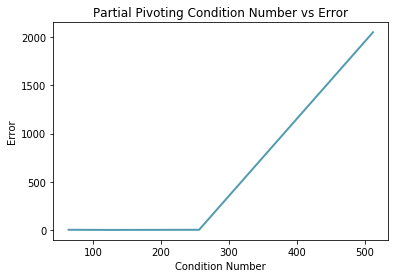

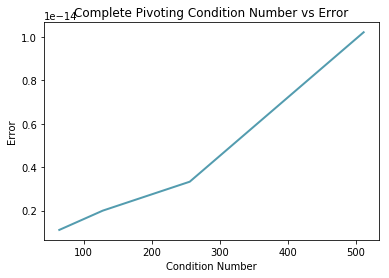

In [141]:
lineplot(condnumbers,errorsPP,'Condition Number','Error','Partial Pivoting Condition Number vs Error')
lineplot(condnumbers,errorsCP,'Condition Number','Error','Complete Pivoting Condition Number vs Error')

From our results we can see that **Gaussian elimination with partial pivoting** is not stable in comparison to Complete Pivoting when is applied to this particular test matrix. The solution is contaminated by unacceptably large roundoff errors associated with large elements encountered during the elimination process. Gaussian elimination with partial pivoting have **error growth that is exponential** in the matrix size n as we can see from the chart. As a sequence, the linear system when A matrix is decomposed with LU Partial Pivoting for size 1024,2048 cannot be solved due to the appearance of **infs** in upper tringle U.


**Gaussian elimination with complete pivoting**, on the other hand, cannot have exponential error growth 

#### Question 4)

We will generate random vectors u,v and dividing by their l2 norm accordingly we will get the unit vectors u,v.
From theory a unit vector is a vector (often a spatial vector) of length 1 and is defined: $$ \hat{u}=\frac{u}{|u|} $$ where |u| is the l2 norm of u


In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [15]:
# construct u,v vectors with l2 norm=1 for all n dimensions
n_array = [64, 128, 256, 512, 1024, 2048]
seed(4)
u_vectors_map = {}
v_vectors_map = {}
for i in n_array:
    u_vector = np.random.randn(i)
    u_vectors_map[i]=normalize(u_vector)
    v_vector = np.random.randn(i)
    v_vectors_map[i]=normalize(v_vector)

In [16]:
# print l2 norm for u_vector of size 64 to confirm is unit vector
l2 = npla.norm(u_vectors_map[64])
print(l2)

1.0


In [17]:
def getRandomLinearSystem(n,u_vectors_map,v_vectors_map):
    seed(4)
    A = np.random.randn(n,n)
    x = np.random.randn(n)
    print('matrix A for n:',n)
    print(A)
    print('solution vector x for n:',n)
    print(x)
    u=u_vectors_map[n]
    v=v_vectors_map[n]
    # (A-u*v.')\b
    b=np.dot((A + u*v.T),x)
    return A,u,v,x,b

To solve linear system (A + uv.T)x = b we are going to use Sherman-Morrison formula to obtain $$x = (A - uv^T )^{-1}b = A^{-1}b + A^{-1}u(1-u^T A^{-1}u)^{-1}v^{T}A^{-1}b $$ which can be implemented by following steps:

* **Solve Az = u**
<br> xx = forwardSubstitution(L,u)
<br> z = backSubstitution(U,xx),

* **Solve Ay = b**
<br> xx = forwardSubstitution(L,b)
<br> y = backSubstitution(U,xx),

* Compute the solution using **Sherman-Morrison formula**
<br> vy = v.'*y
<br> vz = v.'*z
<br> x = y + (vy/(1-vz))*z

In [405]:
from scipy.linalg import solve_triangular
def solveSystemWithPP(A,u,v,b,verbose):
    print('LU decomposition with Gauss Elimination Partial Pivoting')
    Lpart, Upart, Ppart = partialPivotingGE(A,verbose)
    xx = solve_triangular(Lpart,Ppart@u,lower=True)
    z = solve_triangular(Upart,xx,lower=False)
    xx = solve_triangular(Lpart,Ppart@b,lower=True)
    y = solve_triangular(Upart,xx,lower=False)
    vy = v.T*y
    vz = v.T*z
    x = y + (vy/(1-vz))*z
    print("Solutions:\n",x)

In [406]:
verbosePP=False
n=64
A,u,v,x,b = getRandomLinearSystem(n,u_vectors_map,v_vectors_map)
solveSystemWithPP(A,u,v,b,verbosePP)

matrix A for n: 64
[[ 0.05056171  0.49995133 -0.99590893 ...  0.3523434   0.067471
  -0.7322647 ]
 [ 0.29714121 -0.9617768   1.27181862 ...  0.51655963  0.67380149
   1.02645497]
 [-0.68114843 -1.96601472  1.04090637 ... -1.97175308 -0.92708219
   0.34374145]
 ...
 [ 0.367727   -0.32034449 -1.75607263 ... -0.27950187 -0.86224063
  -1.27712852]
 [-1.26464051  0.36997555 -0.67398211 ...  1.54574563  0.27112793
   1.38286855]
 [-0.56783291  2.01625366 -0.60787455 ... -1.63875863  0.86140911
  -1.21189758]]
solution vector x for n: 64
[ 0.69834862 -0.03288943  0.37951421 -0.80497322  1.10851421 -0.40155605
  0.02746032 -0.07929173 -0.57977827  0.03573742 -0.60520969  0.65338477
 -0.82689175 -0.05076208 -0.21804545  0.47545254 -0.02713303  0.17975221
 -0.49170994 -1.07218889 -0.42396604  0.79995441  0.20988126 -0.5719529
 -0.14629356 -1.54493454  0.09209576  0.17937177 -0.44295485  0.49217951
 -1.54305065 -1.21046279  0.41177141 -0.53400947  0.92736509 -0.3476026
  0.51325364  0.72177917  0

#### Since A is already factored, procedure requires only triangular solutions and inner products, so only $O(n^2)$  for matrix-vector multiplications work rather than $O(n^3)$ work required for inversion.